# Random Walks on different networks

## Approach

- Take lattice from graph library and implement MC algorithm 
    - Check for correct behaviour, e.g. diffsuion, end-to-end-distance, every node visited, … 
- Test on other graphs, introduce chaos 
    - Start with lattice and take away nodes 
    - Introduce long range connections to 2d-lattice
    
#### Random walk 
- standard Random walk 
    - Move to any adjacent node with equal probability 
- Lazy random walk 
    - Prob ½ to stay, prob ½ to move (equally distributed over adjacent nodes)
- IDEA: Both could be combined in one function using lazy=True/False argument

#### Problems: 
- Measure for distance in a graph with additional edges? 
    -> If we stick with a lattice, we can define our own underlying distance function d(u,v) 
- Walk only to right and distance gets smaller again
- Kleinberg model: Z=const. for periodic lattice, but for non-periodic boundaries?

## Code

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, fixed
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

### Lattice graph in networkx

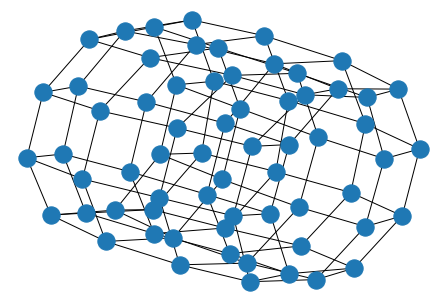

In [2]:
# 2d lattice graph, periodic
L = 8
G = nx.grid_2d_graph(L,L, periodic=True)

# plot
nx.draw(G)

In [3]:
# all nodes have degree 4
nx.degree_histogram(G)

[0, 0, 0, 0, 64]

In [4]:
'''
    Lattice sites are enumerated (row, column) starting on
    upper left with (0,0) ending on lower right with (7,7).
'''
# example: neighbours of node (0,0) and (1,1)
print(list(nx.neighbors(G, (0,0))),'\t', list(nx.neighbors(G, (1,1))))

[(1, 0), (0, 1), (7, 0), (0, 7)] 	 [(0, 1), (2, 1), (1, 0), (1, 2)]


### Starting with random walks

#### Distance functions

In [5]:
def dist_1d(a, b, L):
    '''
    Distance between two points on a periodic 
    line with length L.
    
    Arguments:
    - a: first point (integer 0,..,L-1)
    - b: second point (integer 0,...,L-1)
    - L: number of points on line
    
    Return:
    - d: distance between points
    '''
    # handle usage of bad arguments
    if a>=L or b>=L or a<0 or b<0:
        print('INFO: \na={} or b={} should be in range [0,L-1]=[0,{}]. Using a%L={} or b%L={} instead.\n'.format(a, b, L, a%L, b%L))
        a = a%L
        b = b%L
    if type(a) != int or type(b) != int or type(L) != int:
        print('INFO: \nAll arguments should be type int. You used type(a)={}, type(b)={}, type(L)={}. \nWill be converted using int(..).\n'.format(type(a), type(b), type(L)))
        a, b, L = int(a), int(b), int(L)
        
    # return distance
    d = 0
    if abs(a-b)<L/2.:
        d = abs(a-b)
    else :
        d = L-abs(a-b)
    return d


def dist_2d_lattice(u, v, L):
    '''
    Distance between two node on a periodic 
    lattice graph with side length L.
    
    Arguments:
    - u: first node (tuple (u_0, u_1))
    - v: second node (tuple (v_0, v_1))
    - L: side length of lattice
    
    Return:
    - d: distance between points (-1 if error occured)
    '''
    # handle arguments having wrong types
    if type(u)!=tuple or type(v)!= tuple:
        print('ERROR: \nArguments u and v should be type tuple. You used type(u)={}, type(v)={}. \nBreak and return -1\n'.format(type(u), type(v)))
        return -1
    if type(L)!=int:
        print('INFO: \nArgument L should be type int. You used type(L)={}. Now using int(L)={}\n'.format(type(L), int(L)))
        L=int(L)
    
    d = dist_1d(u[0], v[0], L) + dist_1d(u[1], v[1], L)
    return d

#### Checking our 2d lattice distance and nx.shortest_path_length() algorithm for similar results

In [6]:
u = (0,0)
v = (4,4)
# compare measures

print('Distance between nodes u={}, v={} on 2d lattice graph G with side length L={}'.format(u, v, L),
      '\n\nUsing dist_2d_lattice():', dist_2d_lattice(u,v,L),
      '\nUsing nx.shortest_path_length() on G:', nx.shortest_path_length(G, source=u, target=v))

Distance between nodes u=(0, 0), v=(4, 4) on 2d lattice graph G with side length L=8 

Using dist_2d_lattice(): 8 
Using nx.shortest_path_length() on G: 8


#### Random walk functions

In [495]:
def simple_2d_random_walk(G, L, max_steps, start_node=(0,0), use_random_starting_node=False, return_end=False):
    '''
    Perform a simple random walk on a given graph G, which should be based on a 2d lattice.
    In one step the random walker with equal probability traverses any of the incident edges 
    of the current node to a neighboring node. 
    
    Arguments:
    - G: graph, based on a 2d lattice
    - L: side length L of the 2d lattice base of G
    - max_steps: number of steps the random walker takes in total
    - start_node: node to start random walk from, default=(0,0)
    - use_random_starting_node: start on a randomly chosen node, default=False
    
    Return:
    - path: list of edges the random walker traversed (format: [(node1, node2), (node2, node3)])
    '''
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # randomly choose from neighbors of current node
        new_node = tuple(np.random.permutation(list(G[current_node].keys()))[0])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    if return_end:
        return path[len(path)-1][1]
    else:
        return path


def lazy_2d_random_walk(G, L, max_steps, start_node=(0,0), use_random_starting_node=False, return_end=False):
    '''
    Perform a lazy random walk on a given graph G, which should be based on a 2d lattice.
    In one step the random walker stays at the current node with probability 1/2 and with 
    probability 1/2d_n traverses any of the d_n incident edges of the current node to a 
    neighboring node. 
    
    Arguments:
    - G: graph, based on a 2d lattice
    - L: side length L of the 2d lattice base of G
    - max_steps: number of steps the random walker takes in total
    - start_node: node to start random walk from, default=(0,0)
    - use_random_starting_node: start on a randomly chosen node, default=False
    
    Return:
    - path: list of edges the lazy random walker traversed (format: [(node1, node2), (node2, node3)])
    '''
    if use_random_starting_node:
        current_node = tuple(np.random.randint(0, L, 2))
    else:
        current_node = start_node
        
    path=[]
    # for-loop over max_steps
    for t in range(max_steps):
        # stay at current node with p=1/2 or move to a neighboring 
        # node with each p=1/2d_n (d_n degree of current node)
        if np.random.uniform(0,1) <= 0.5:
            new_node = current_node
        else:
            new_node = tuple(np.random.permutation(list(G[current_node].keys()))[0])
        # append new node to path
        path.append((current_node, new_node))
        current_node = new_node
    if return_end:
        return path[len(path)-1][1]
    else:
        return path

#### Draw simple random walk

In [8]:
def plot_walk(G, L, total_path, steps=-1, figure_size=(10,10)):
    # take only specified steps of path (-1 -> complete path)
    path = total_path[:steps]
    # color map
    color_map=[]
    for node in G:
        if node == path[0][0]:
            color_map.append('red') #INITIAL POINT RED
        elif node == path[-1][1]: 
            color_map.append('blue') #END POINT BLUE
        else:
            color_map.append('lightgreen')

    # FIGURE
    plt.figure(figsize=figure_size)
    # make graph R to display the path
    R = nx.grid_2d_graph(L,L,periodic=True)
    R.remove_edges_from(list(R.edges))
    R.add_edges_from(path)
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    # draw underlying network
    nx.draw(G, pos=pos, 
        node_color='lightgreen', 
        edge_color='lightgray',
        with_labels=False,
        node_size=100,
        width=3)
    # draw path using R
    nx.draw(R, pos=pos, 
        node_color=color_map, 
        with_labels=False,
        node_size=100,
        edge_color='red',
        width=2)
    plt.show()

In [414]:
# T steps of random walk
# always same starting point (0,0)
L=10 # lattice side length
T=100 # steps
G = nx.grid_2d_graph(L, L, periodic=True)

path = simple_2d_random_walk(G, L, T, use_random_starting_node=True)

# plot interactive walk
interact(plot_walk, G=fixed(G), L=fixed(L), total_path=fixed(path), steps=(1, len(path)), figure_size=fixed((10,10)))

interactive(children=(IntSlider(value=1, description='steps', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.plot_walk(G, L, total_path, steps=-1, figure_size=(10, 10))>

#### 2-d Kleinberg model

Our task is to simulate a small world network, the probability matrix is defined as follows
\begin{equation}
P(u,v)={\text{dist}(u,v)^{-r}\over Z} \qquad Z=\sum_{y\neq u}\text{dist}(u,y)^{-r}
\end{equation}
This graph is therefore represented by two number $G(N,r)$ and it has a geometric structur of a torus $T=\{1,\dots,N\}^2$.

The distance is defined as follow, with this notation of the vertices $u=(u_1,u_2)\in \{1,\dots,N\}^2$
\begin{equation}
	\text{dist}(u,v)=d_N(|u_1-v_1|)+d_N(|u_2-v_2|)
\end{equation}
and $d_N$ is the one dimensional distance over a circular graph
\begin{equation}
	d_N(i)=\begin{cases}i \quad 0\leq i<N/2\\
	N-i\quad N/2\leq i\leq N
	\end{cases}
\end{equation}
We have to start from a periodic 2d lattice

In [582]:
def Kleinberg_2d(L,r):
    G = nx.grid_2d_graph(L,L, periodic=True)
    Z=0
    for y in G:
        if y!=(0,0):
            Z=Z+dist_2d_lattice((0,0),y,L)**(-r)
    for x in G:
        for y in G:
            if x>y: #to avoid self loops and also double count on the edges
                if np.random.uniform(0, 1)<(dist_2d_lattice(x,y,L)**(-r)/Z):
                    G.add_edge(x,y) 
    return G

#new definition of small world
def small_world(L,r):
    G = nx.grid_2d_graph(L,L, periodic=True)
    Z=0
    for y in G:
        if y!=(0,0):
            d=dist_2d_lattice((0,0),y,L)
            if d>=2: #here there's the difference
                Z=Z+d**(-r)
    for x in G:
        for y in G:
            if x>y: #to avoid self loops and also double count on the edges
                if np.random.uniform(0, 1)<(dist_2d_lattice(x,y,L)**(-r)/Z):
                    G.add_edge(x,y) 
    return G

**Drawing 2-d kleinber random walk**

In [595]:
L=10
r=1
T=100
K=Kleinberg_2d(L,r)
path = simple_2d_random_walk(K, L, T, use_random_starting_node=True)
interact(plot_walk, G=fixed(Kleinberg_2d(L,r)), L=fixed(L), total_path=fixed(path), steps=(1, len(path)), figure_size=fixed((10,10)))

interactive(children=(IntSlider(value=1, description='steps', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.plot_walk(G, L, total_path, steps=-1, figure_size=(10, 10))>

**Drawing 2-d small world (from the paper)**

In [597]:
L=10
r=4
T=100
K=small_world(L,r)
path = lazy_2d_random_walk(K, L, T, use_random_starting_node=True)
interact(plot_walk, G=fixed(Kleinberg_2d(L,r)), L=fixed(L), total_path=fixed(path), steps=(1, len(path)), figure_size=fixed((10,10)))

interactive(children=(IntSlider(value=1, description='steps', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.plot_walk(G, L, total_path, steps=-1, figure_size=(10, 10))>

## Analysis of the random path

For a lazy random walk on the kleinberg model the mixing time has this behaviour against the total number of nodes
\begin{equation}
	T_{mix}=\begin{cases}\Theta(\log n) & \text{if } r<2\\
	O((\log n)^4) & \text{if } r=2\\
	n^{\Omega(1)} & \text{if } r>2
	\end{cases}
\end{equation}
Where the mixing time is definde as
\begin{equation}
	T_{mix}=\min\bigg\{t\in Z|\max_{v\in V}||P^{t}(v,\dot)-{\bf \pi}||_{TV}\leq {1\over 4}\bigg\}
\end{equation}
$\pi$ is the stationary distribution.
\begin{equation}
\pi=(\pi_v)_{v\in V} \qquad \pi_v={d_v/2|E|} \qquad |E| \text{ number of edges}
\end{equation}
The norm is the *Total Variance distance between two probability measure* and in this case it boils down to the $L_1$ norm
\begin{equation}
||P^{t} (v,)-{\bf \pi}||_{TV}={1\over 2}||P^{t}(v,)-{\bf \pi}||_1
\end{equation}

# Probabilty distribution of end points of a random walk

In [573]:
# we create a function that fills a vector with M=1000 end points of a T steps random walk
# let's try first on a 2d lattice
    
L=10
T=100 #steps
G=nx.grid_2d_graph(L, L, periodic=True)
M=1000 #number of end points in the vector
end_point=[]
for x in range(M):
    end=simple_2d_random_walk(G, L, T, use_random_starting_node=False, return_end=True)
    end_point.append(end)


After have created the vector end_point we have to create a probability vector from it

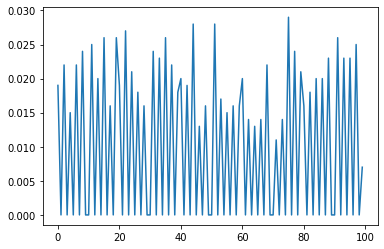

In [574]:
prob=[]
for x in G:
    freq=0
    for y in end_point:
        if y==x:
            freq=freq+1
    prob.append(freq)
relative_prob=np.array(prob)
relative_prob=relative_prob/M      
plt.plot(relative_prob)

For an even L we get basically half of the point off the end point (this is a consequence of the nature of our random walk). 

In [576]:
'''
    definition of function that gives the probability, with M=1000 samples, to get to an arbitrary point 
    after T step of a random walk
'''
def prob_distribution(G, L, T, M=1000):
    end_point=[]
    #L=np.sqrt(nx.number_of_nodes(G))
    for x in range(M):
        end=simple_2d_random_walk(G, L, T, use_random_starting_node=False, return_end=True)
        end_point.append(end)
    prob=[]
    for x in G:
        freq=0
        for y in end_point:
            if y==x:
                freq=freq+1
        prob.append(freq)
    relative_prob=np.array(prob)
    relative_prob=relative_prob/len(end_point)   
    return relative_prob

We compute now the L_1 norm against the T steps of a random walk

Text(0, 0.5, 'total variance')

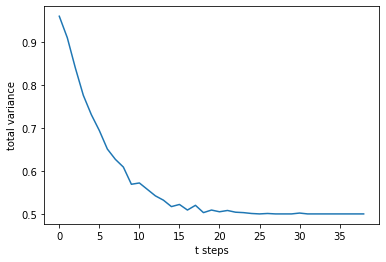

In [577]:
norm_vector=[]
L=10
G=nx.grid_2d_graph(L, L, periodic=True)
E=nx.number_of_edges(G)
for T in range(1,40):
    norm=0
    prob=prob_distribution(G, L, T)
    #plt.plot(prob)
    t=0 # index for prob[]
    for x in G:
        norm=norm+0.5*abs(prob[t] - G.degree(x)/(2*E))
        t=t+1
    norm_vector.append(norm)
plt.plot(norm_vector)
plt.xlabel('t steps')
plt.ylabel('total variance')

For some reason for L even the total variation with the stationary distribution has 0.5 as lower bound 

Text(0, 0.5, 'total variance')

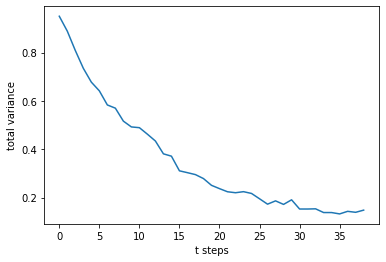

In [581]:
norm_vector=[]
L=9
G=nx.grid_2d_graph(L, L, periodic=True)
E=nx.number_of_edges(G)
for T in range(1,40):
    norm=0
    prob=prob_distribution(G, L, T)
    #plt.plot(prob)
    t=0 # index for prob[]
    for x in G:
        norm=norm+0.5*abs(prob[t] - G.degree(x)/(2*E))
        t=t+1
    norm_vector.append(norm)
plt.plot(norm_vector)
plt.xlabel('t steps')
plt.ylabel('total variance')